Перед вами то, с чем я последние два раза участвовал в соревновании на Numer.ai. Numer.ai -- это сайт, куда раз в несколько дней заливают датасет с некими зашифрованными данными с фондового рынка. Что за данные -- никто не знает. Выглядят они как сотня тысяч объектов с 21 характеристикой для каждого. Характеристики нормализованы, для каждого объекта есть прогноз в виде цифры -- 0 или 1. На эти данные слетается стая дата-аналитиков, которые всячески их ковыряют, пытаются найти закономерность и построить предсказания для тестовой выборки. 
Построенные предсказания заливаются на сайт, где формируется рейтинг. 
Итак, я решил сделать нейронную сеть и посмотреть, насколько хорошо она сумеет предсказывать поведение фондового рынка. 

In [1]:
#Импортируем всем известные библиотеки для работы с данными и визуализации. 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
#Импортируем то, что нам потребуется, из Keras. Keras представляет собой удобную обертку, позволяющую
#в десяти строчках набросать план сети, который потом будет скомпилирован в код для Tensorflow или Theano. 
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.optimizers import RMSprop
from keras.layers.normalization import BatchNormalization

Using Theano backend.


In [2]:
#Теперь загрузим данные в фиде датафрейма Pandas.
data = pd.read_csv('numerai_training_data.csv')
tournament_data = pd.read_csv('numerai_tournament_data.csv')

In [3]:
#Данные загружены, посмотрим на первые 5 элементов обучающей выборки. 
data.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,target
0,0.497449,0.722213,0.788587,0.395164,0.503541,0.301560,0.417738,0.805707,0.585739,0.538008,...,0.878240,0.477429,0.993930,0.944011,0.459007,0.838756,0.843865,0.543250,0.639446,0
1,0.314430,0.442740,0.753186,0.651303,0.833048,0.867722,0.662809,0.021921,0.568605,0.878457,...,0.974295,0.733731,0.917947,0.913460,0.696632,0.579482,0.085998,0.583732,0.216417,1
2,0.542753,0.749818,0.490253,0.387866,0.227817,0.763056,0.297321,0.443098,0.086525,0.627223,...,0.005009,0.857279,0.042383,0.508560,0.129168,0.949880,0.325948,0.462809,0.985990,1
3,0.789343,0.624176,0.766418,0.004252,0.321829,0.019919,0.554157,0.749399,0.462002,0.859457,...,0.298401,0.087682,0.206709,0.110735,0.344979,0.806925,0.775105,0.165180,0.664026,0
4,0.046066,0.815840,0.990431,0.890012,0.218559,0.865423,0.968102,0.032305,0.978947,0.515481,...,0.215636,0.927498,0.373143,0.469240,0.257145,0.900540,0.236400,0.450724,0.217831,1


Прелестно. Как я уже говорил, нормализованные значения для каждого из 21 признаков. 

In [4]:
data.describe()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,target
count,96320.000000,96320.000000,96320.000000,96320.000000,96320.000000,96320.000000,96320.000000,96320.000000,96320.000000,96320.000000,...,96320.000000,96320.000000,96320.000000,96320.000000,96320.000000,96320.000000,96320.000000,96320.000000,96320.000000,96320.000000
mean,0.501308,0.503716,0.501427,0.486071,0.493400,0.493860,0.496498,0.503367,0.513762,0.498529,...,0.510348,0.503008,0.511927,0.506167,0.517150,0.505737,0.494409,0.499872,0.500035,0.505170
std,0.291842,0.292209,0.285400,0.300743,0.293895,0.297529,0.289816,0.285681,0.286873,0.282871,...,0.288563,0.290839,0.294987,0.288653,0.286636,0.293463,0.284507,0.290365,0.286790,0.499976
min,0.000000,0.000000,0.000140,0.000000,0.000001,0.000000,0.000003,0.000000,0.000000,0.000047,...,0.000172,0.000000,0.000000,0.000044,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.249180,0.255837,0.257397,0.207111,0.228888,0.237490,0.245053,0.256400,0.268969,0.254813,...,0.267601,0.249391,0.259434,0.261992,0.278682,0.243173,0.258169,0.256621,0.246962,0.000000
50%,0.513009,0.500508,0.507568,0.468725,0.482481,0.491627,0.474248,0.508466,0.522486,0.502711,...,0.528477,0.498782,0.526806,0.497373,0.530667,0.501241,0.489472,0.493700,0.508131,1.000000
75%,0.750271,0.760975,0.752563,0.750496,0.764957,0.761369,0.751249,0.742915,0.754200,0.735110,...,0.761483,0.765621,0.776614,0.754841,0.777363,0.764578,0.739163,0.757143,0.749227,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Ничего не понятно. Ну и ладно.

In [5]:
#Представим обучающие и тестовые данные в виде матрицы numpy. 
data = np.asmatrix(data)
X_tournament = np.asmatrix(tournament_data)

In [6]:
#Необходимо отделить колонку с ответами от обучающей выборки. 
X = data[:, :-1]
y = data[:, -1]

In [7]:
#Давайте категоризируем колонку с ответами. 
y = list(map(int, y))
y = np_utils.to_categorical(y)

Посмотрим, что получилось. 

In [8]:
X

matrix([[ 0.49744944,  0.72221282,  0.78858684, ...,  0.84386477,
          0.54324979,  0.63944586],
        [ 0.31442953,  0.4427403 ,  0.75318584, ...,  0.08599803,
          0.58373233,  0.21641711],
        [ 0.54275321,  0.74981753,  0.49025285, ...,  0.32594778,
          0.46280914,  0.98598974],
        ..., 
        [ 0.73803547,  0.29122605,  0.2493957 , ...,  0.5332935 ,
          0.74179524,  0.63491802],
        [ 0.0861853 ,  0.44291676,  0.63376541, ...,  0.11093683,
          0.27755192,  0.68037441],
        [ 0.29247344,  0.79481648,  0.79898224, ...,  0.71241487,
          0.93436928,  0.58259562]])

С обучающей выборкой все в порядке.

In [9]:
y

array([[ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       ..., 
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

С ответами для обучающей выборки тоже все в порядке. 
Теперь делаем сеть. 

In [10]:
#В нашей модели будет три слоя. В первых двух по 42 нейрона, в третьем 2. 
#В качестве борьбы с переобучением используем дропаут. 
model = Sequential()
model.add(Dense(42, input_dim=21, init='uniform', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(42, init='uniform', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(2, init='uniform', activation='softmax'))
#Сразу скомпилируем. 
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

In [19]:
#Число эпох задаю через переменную для последующей визуализации.
n = 40

In [20]:
#Обучаем нашу сеть. Пятую часть выборки используем как валидацию. Лучшие результаты пишем в файл. 
history = model.fit(X, y,
          batch_size=100, nb_epoch=n, verbose=1,
          validation_split=0.2,
          callbacks=[ModelCheckpoint(filepath=\
          "/home/ubuntu/weights.hdf5",\
          verbose=1, save_best_only=True)]
          )

Train on 77056 samples, validate on 19264 samples
Epoch 1/40
77056/77056 [==============================] - 1s - loss: 0.6923 - acc: 0.5175 - val_loss: 0.6925 - val_acc: 0.5209
Epoch 2/40
77056/77056 [==============================] - 1s - loss: 0.6923 - acc: 0.5176 - val_loss: 0.6921 - val_acc: 0.5161
Epoch 3/40
77056/77056 [==============================] - 1s - loss: 0.6924 - acc: 0.5174 - val_loss: 0.6919 - val_acc: 0.5215
Epoch 4/40
77056/77056 [==============================] - 1s - loss: 0.6922 - acc: 0.5175 - val_loss: 0.6921 - val_acc: 0.5209
Epoch 5/40
77056/77056 [==============================] - 1s - loss: 0.6921 - acc: 0.5192 - val_loss: 0.6927 - val_acc: 0.5210
Epoch 6/40
77056/77056 [==============================] - 1s - loss: 0.6921 - acc: 0.5180 - val_loss: 0.6920 - val_acc: 0.5200
Epoch 7/40
77056/77056 [==============================] - 1s - loss: 0.6921 - acc: 0.5175 - val_loss: 0.6920 - val_acc: 0.5221
Epoch 8/40
77056/77056 [==============================] - 1s 

In [21]:
#Вытаскиваем историю обучения из модели. 
loss_history = history.history['loss']
acc_history = history.history['acc']
epochs = [(x + 1) for x in range(n)]

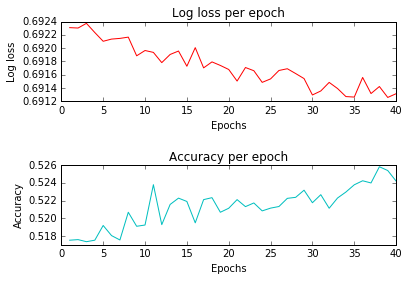

In [22]:
#Посмотрим, как она училась.
%matplotlib inline
ax = plt.subplot(211)
ax.plot(epochs, loss_history, color='red')
ax.set_xlabel('Epochs')
ax.set_ylabel('Log loss')
ax.set_title('Log loss per epoch')
ax2 = plt.subplot(212)
ax2.plot(epochs, acc_history, color='c')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy per epoch')
plt.subplots_adjust(hspace=0.8)

plt.show()

На вид вроде бы ничего. Перекрестная энтропия снижается, точность растет. Говорит ли это о том, что мы получим хоть сколько-нибудь приемлемый результат? Очевидно, нет, потому что на валидации качество вовсе не росло. 

In [23]:
#Берем сохраненные моделью самые лучшие веса. 
model.load_weights('/home/ubuntu/weights.hdf5')

In [24]:
#Получаем матрицу с предсказаниями. 
result = np.hstack((X_tournament[:, 0], model.predict_proba(X_tournament[:, 1:], verbose=0)))

In [25]:
result
#Первая колонка -- индекс объекта, вторая и третья -- вероятности, что объект принадлежит одному из классов

matrix([[  1.97780000e+04,   4.80625153e-01,   5.19374847e-01],
        [  2.14650000e+04,   4.58532095e-01,   5.41467905e-01],
        [  2.54930000e+04,   5.32102823e-01,   4.67897177e-01],
        ..., 
        [  2.00740000e+04,   4.24620837e-01,   5.75379193e-01],
        [  2.67870000e+04,   5.32578230e-01,   4.67421740e-01],
        [  1.00620000e+04,   4.57302570e-01,   5.42697430e-01]])

Осталось записать результат в файл. 

In [26]:
columns = ['t_id', 'probability']
dtype = [('t_id','int'), ('probability','float')]
values = result[:, [0, 1]]
df = pd.DataFrame(values, columns = columns)
df[['t_id']] = df[['t_id']].astype(int)
df.to_csv('lol.csv', index = False)

Загружаем предсказание на сайт и убеждаемся, что модель совершенно неэффективна, а полученный нами результат никуда не годится. Log loss равен 0.69097, все равно как при случайном угадывании. В принципе, можно было потратить пять минут на случайный лес или градиентный бустинг и получить то же самое. 
Лучшие результаты модель дает при наименьшем количестве эпох -- пока она еще не сумела найти какую-то псевдозакономерность и подогнаться под нее. 
Судя по всему, лидеры рейтинга с результатом 0.64 знают о признаках то, чего не знаем мы. 